In [2]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
)
import xgboost as xgb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dropout,LSTM, Dense, SpatialDropout1D, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

nltk.download('stopwords')  # Download stopwords list
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Unzip WordNet data

# Set maximum number of words
max_words = 5000  # Limit on the number of words to consider

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:

data1 = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
data3 = pd.read_csv("/kaggle/input/disaster-tweets/tweets.csv")
spam = pd.read_csv('/kaggle/input/sms-spam-collection/SMSSpamCollection.csv', header=None)

spam[['text', 'target']] = spam[0].str.split('\t', n=1, expand=True)
spam['target'] = spam['target'].map({'ham': 0, 'spam': 1})
spam = spam.drop(columns=[0])
data = pd.concat([data1, data3, spam], ignore_index=True)
data = data.drop_duplicates(subset='text', keep='first')
data = data[['text', 'target']]
data.dropna(inplace=True)
data.head()


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1.0
1,Forest fire near La Ronge Sask. Canada,1.0
2,All residents asked to 'shelter in place' are ...,1.0
3,"13,000 people receive #wildfires evacuation or...",1.0
4,Just got sent this photo from Ruby #Alaska as ...,1.0


In [6]:
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # 1. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    
    # 2. Remove special characters, punctuation, and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    
    # 3. Convert text to lowercase
    text = text.lower()
    
    # 4. Remove stopwords
    stop_words = set(stopwords.words('english'))
    pronouns_to_keep={'he', 'she', 'they','our', 'it', 'i' 'we', 'you', 'him', 'her', 'them', 'us', 'me'}

    # Remove pronouns from stop words
    stop_words -= pronouns_to_keep
    
    text_tokens = text.split()  # Tokenize text
    text_tokens = [word for word in text_tokens if word not in stop_words]
    
    # 5. Lemmatization (convert words to base form)
    text_tokens = [lemmatizer.lemmatize(word) for word in text_tokens]
    
    # Join tokens back into a single string
    cleaned_text = ' '.join(text_tokens)
    return cleaned_text
data['text_clean']=data['text'].apply(preprocess_text)
# Step 3: Split the dataset into train and test sets
X = data['text_clean']
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
y_train.isnull().sum()

0

In [8]:
def evaluate_model(model, X_test, y_test, is_keras=False, is_svc=False):
    """
    Function to evaluate a Keras, SVC, or scikit-learn model and print various metrics 
    like accuracy, precision, recall, F1-Score, confusion matrix, and plot ROC curve.
    
    Parameters:
    model: Trained model to evaluate (could be Keras, SVC, or scikit-learn model).
    X_test: Test data features.
    y_test: True labels for test data.
    is_keras: Boolean indicating if the model is a Keras model.
    is_svc: Boolean indicating if the model is an SVC model.
    
    Returns:
    None (prints out the results and plots)
    """
    # Step 3: Make predictions
    if is_keras:
        # For Keras models, we use predict to get probabilities
        y_pred_probs = model.predict(X_test)
        y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
    elif is_svc:
        # For SVC, we use decision_function for the ROC curve
        y_pred = model.predict(X_test)
        y_pred_probs = model.decision_function(X_test)  # Decision function for ROC curve
    else:
        # For scikit-learn models (like Logistic Regression), predict gives labels
        y_pred = model.predict(X_test)
        if hasattr(model, 'predict_proba'):
            y_pred_probs = model.predict_proba(X_test)[:, 1]  # Get probabilities for ROC curve
        else:
            y_pred_probs = None
    
    # Step 4: Evaluate the model
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Precision, Recall, F1-Score
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix:\n{cm}")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title("Confusion Matrix")
    plt.show()
    
    # Specificity (True Negative Rate)
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    print(f"Specificity (True Negative Rate): {specificity:.2f}")
    
    # Classification report for detailed metrics
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Step 5: ROC Curve and AUC-ROC (if probabilities or decision function are available)
    if y_pred_probs is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        roc_auc = auc(fpr, tpr)
        print(f"AUC-ROC: {roc_auc:.2f}")
        
        # Plot ROC Curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.show()
    else:
        print("ROC Curve and AUC cannot be computed without probability predictions or decision function.")


def predict_new_text(model, vectorizer, new_text):
    """
    Function to predict the label for new text.
    
    Parameters:
    model: Trained model.
    vectorizer: TF-IDF vectorizer used for training.
    new_text: List of new text(s) to predict on.
    
    Returns:
    Predicted label(s) for the new text.
    """
    new_text_tfidf = vectorizer.transform(new_text)
    prediction = model.predict(new_text_tfidf)
    print(f"Prediction for the new text: {prediction}")
    return prediction


Accuracy: 0.83
Precision: 0.70
Recall (Sensitivity): 0.70
F1-Score: 0.70
Confusion Matrix:
[[2374  320]
 [ 316  735]]


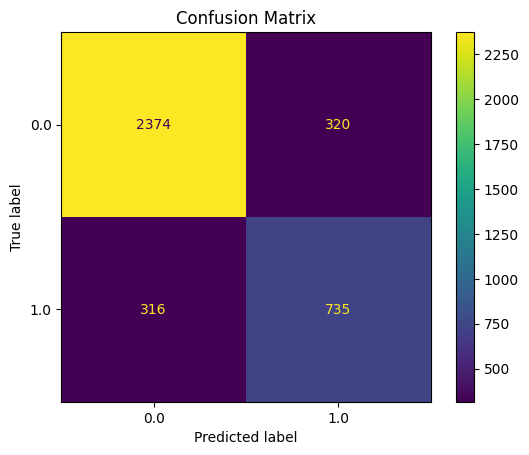

Specificity (True Negative Rate): 0.88

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.88      0.88      2694
         1.0       0.70      0.70      0.70      1051

    accuracy                           0.83      3745
   macro avg       0.79      0.79      0.79      3745
weighted avg       0.83      0.83      0.83      3745

AUC-ROC: 0.79


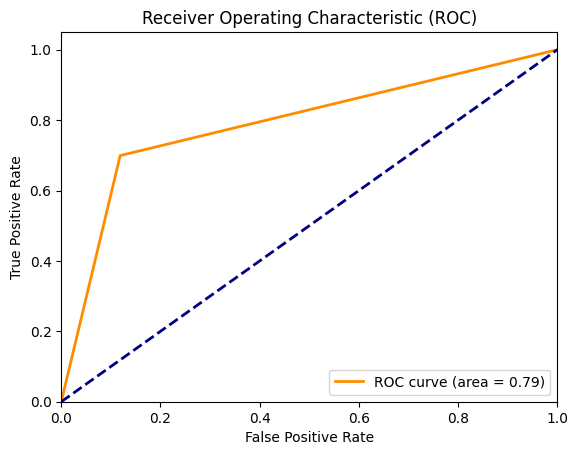

Prediction for the new text: [1.]


array([1.])

In [17]:
#Logistic Regresssion
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

model = LogisticRegression(class_weight={0: 1, 1: 2})  # Assign higher weight to target 1
model.fit(X_train_tfidf, y_train)

evaluate_model(model, X_test_tfidf, y_test, vectorizer)

new_text = ["There is a fire in California right now!"]
predict_new_text(model, vectorizer, new_text)


In [8]:
with open('logistic_regression_model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('tfidf_vectorizer.pkl', 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


Accuracy: 0.83
Precision: 0.78
Recall (Sensitivity): 0.56
F1-Score: 0.65
Confusion Matrix:
[[2528  166]
 [ 464  587]]


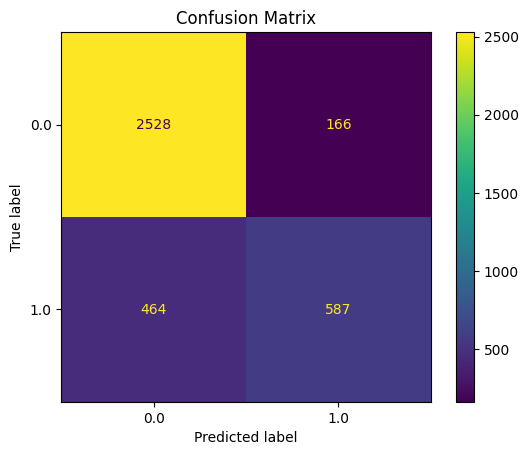

Specificity (True Negative Rate): 0.94

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.94      0.89      2694
         1.0       0.78      0.56      0.65      1051

    accuracy                           0.83      3745
   macro avg       0.81      0.75      0.77      3745
weighted avg       0.83      0.83      0.82      3745

AUC-ROC: 0.75


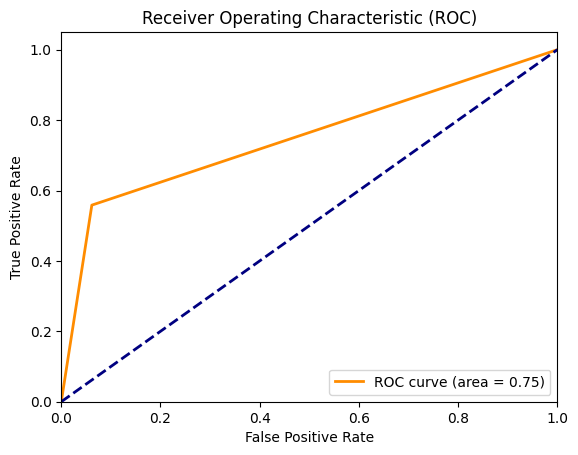

Prediction for the new text: [1.]


array([1.])

In [10]:
#Random Forest
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

evaluate_model(rf_model, X_test_tfidf, y_test, vectorizer)
new_text = ["There is a fire in California right now!"]

predict_new_text(rf_model, vectorizer, new_text)


Accuracy: 0.82
Precision: 0.80
Recall (Sensitivity): 0.45
F1-Score: 0.58
Confusion Matrix:
[[2577  117]
 [ 573  478]]


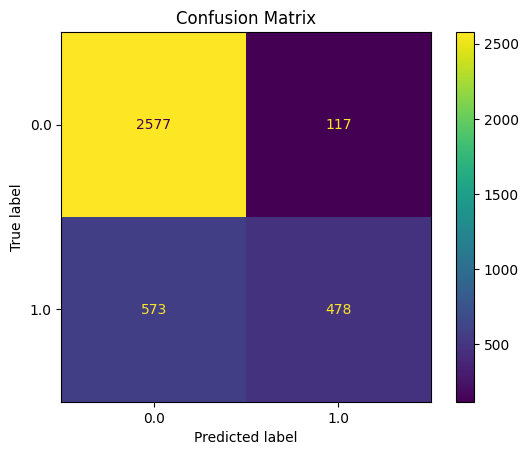

Specificity (True Negative Rate): 0.96

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.96      0.88      2694
         1.0       0.80      0.45      0.58      1051

    accuracy                           0.82      3745
   macro avg       0.81      0.71      0.73      3745
weighted avg       0.81      0.82      0.80      3745

AUC-ROC: 0.71


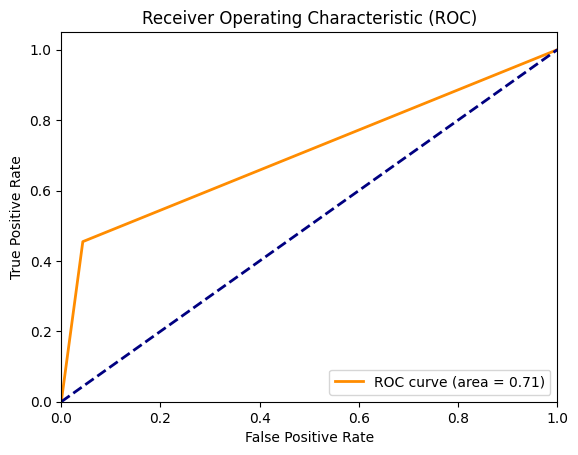

Prediction for the new text: [1]


array([1])

In [11]:

#XGBoost Classifier
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train)

evaluate_model(xgb_model, X_test_tfidf, y_test, vectorizer)

new_text = ["There is a fire in California right now!"]
predict_new_text(xgb_model, vectorizer, new_text)

Accuracy: 0.82
Precision: 0.67
Recall (Sensitivity): 0.70
F1-Score: 0.68
Confusion Matrix:
[[2328  366]
 [ 314  737]]


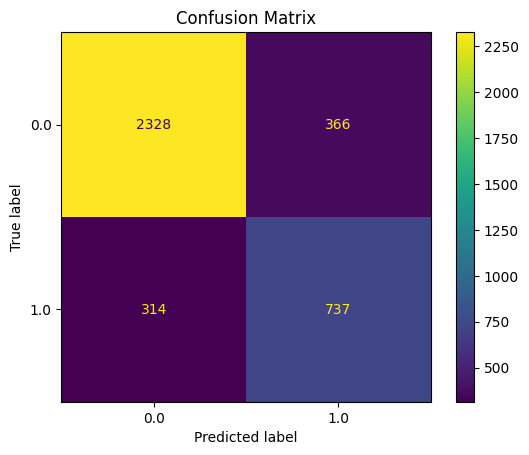

Specificity (True Negative Rate): 0.86

Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87      2694
         1.0       0.67      0.70      0.68      1051

    accuracy                           0.82      3745
   macro avg       0.77      0.78      0.78      3745
weighted avg       0.82      0.82      0.82      3745

AUC-ROC: 0.78


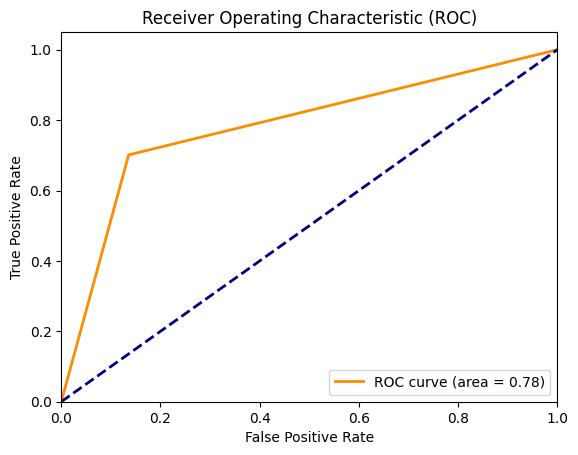

Prediction for the new text: [1.]


array([1.])

In [13]:
#Support Vector Machine
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 5: Train an SVM model
svm_model = SVC(kernel='linear', class_weight={0: 1, 1: 2}, random_state=42)
svm_model.fit(X_train_tfidf, y_train)

# Step 6: Make predictions
evaluate_model(svm_model, X_test_tfidf, y_test, vectorizer,is_svc=True)
new_text = ["There is a fire in California right now!"]

predict_new_text(svm_model, vectorizer, new_text)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.7422 - loss: 0.5521 - val_accuracy: 0.8418 - val_loss: 0.3862
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.9018 - loss: 0.2569 - val_accuracy: 0.8224 - val_loss: 0.4374
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.9652 - loss: 0.1122 - val_accuracy: 0.8271 - val_loss: 0.4879
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9719 - loss: 0.0884 - val_accuracy: 0.8047 - val_loss: 0.6354
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.9836 - loss: 0.0561 - val_accuracy: 0.8134 - val_loss: 0.6589
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9857 - loss: 0.0478 - val_accuracy: 0.8041 - val_loss: 0.7334
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9875 - loss: 0.0386 - val_accuracy: 0.7850 - val_loss: 0.8042
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9887 - loss: 0.0315 - val_ac

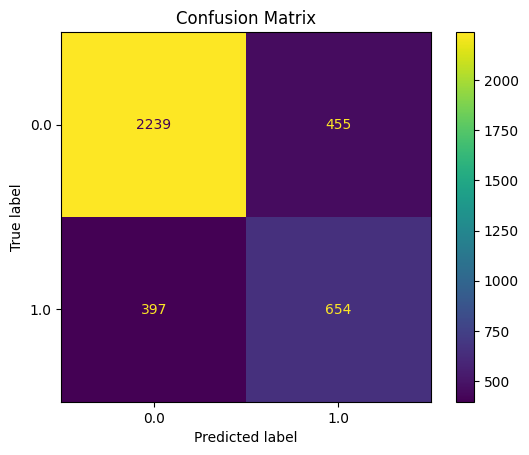

Specificity (True Negative Rate): 0.83

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.83      0.84      2694
         1.0       0.59      0.62      0.61      1051

    accuracy                           0.77      3745
   macro avg       0.72      0.73      0.72      3745
weighted avg       0.78      0.77      0.77      3745

AUC-ROC: 0.80


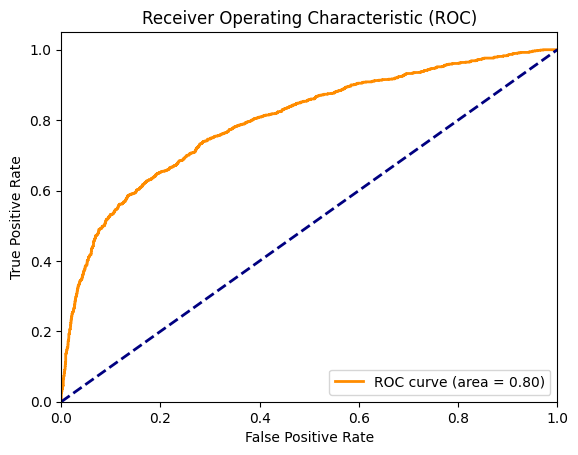

In [18]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
max_length = 100  # Maximum length of sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Step 2: Build the RNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=max_length))
model.add(SimpleRNN(64))  # You can also use LSTM or GRU
model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Step 3: Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
# Step 4: Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)  # To prevent overfitting
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_split=0.2)#, callbacks=[early_stopping])

evaluate_model(model,X_test_pad,y_test,is_keras=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 93ms/step - accuracy: 0.7603 - loss: 0.5060 - val_accuracy: 0.8409 - val_loss: 0.3882
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 45s 95ms/step - accuracy: 0.8852 - loss: 0.2982 - val_accuracy: 0.8342 - val_loss: 0.4076
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 94ms/step - accuracy: 0.9276 - loss: 0.2045 - val_accuracy: 0.8307 - val_loss: 0.4706
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 95ms/step - accuracy: 0.9495 - loss: 0.1346 - val_accuracy: 0.8262 - val_loss: 0.6139
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 81s 92ms/step - accuracy: 0.9654 - loss: 0.0910 - val_accuracy: 0.8134 - val_loss: 0.7220
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 82s 92ms/step - accuracy: 0.9700 - loss: 0.0714 - val_accuracy: 0.8208 - val_loss: 0.7925
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 44s 93ms/step - accuracy: 0.9818 - loss: 0.0490 - val_accuracy: 0.8027 - val_loss: 0.8749
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 92ms/step - accuracy: 0.9841 - loss: 0.0400 - 

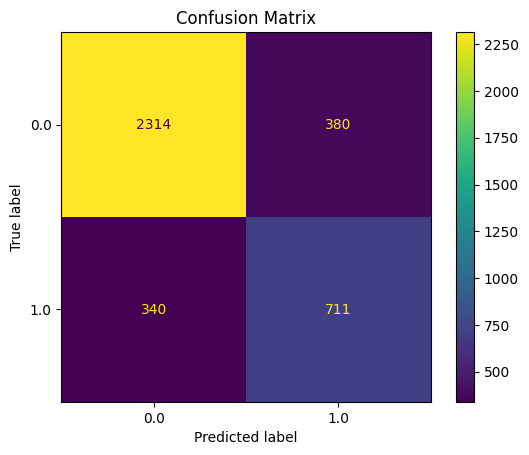

Specificity (True Negative Rate): 0.86

Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.86      0.87      2694
         1.0       0.65      0.68      0.66      1051

    accuracy                           0.81      3745
   macro avg       0.76      0.77      0.76      3745
weighted avg       0.81      0.81      0.81      3745

AUC-ROC: 0.83


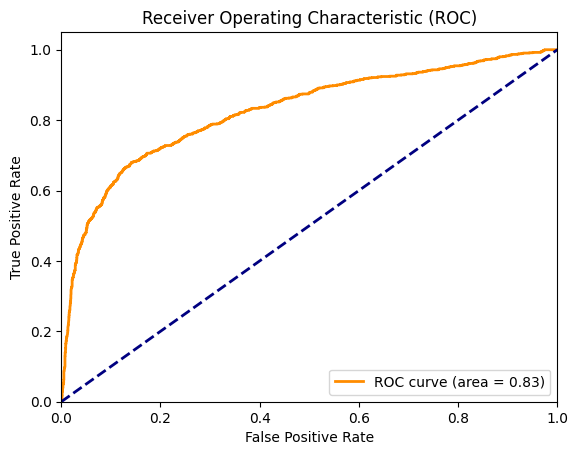

In [15]:
# Parameters
max_words = 10000  # Maximum number of words in the vocabulary
max_length = 100   # Maximum length of sequences
embedding_dim = 128  # Dimensionality of the embedding space

# Tokenizing the texts
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

# Step 2: Build the Stacked RNN model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length))

# Adding two stacked LSTM layers
model.add(LSTM(64, return_sequences=True))  # First LSTM layer
model.add(Dropout(0.5))  # Dropout for regularization
model.add(LSTM(32))  # Second LSTM layer

model.add(Dense(1, activation='sigmoid'))  # For binary classification

# Step 3: Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary of the model
model.summary()

# Step 4: Train the model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

evaluate_model(model, X_test_pad, y_test, is_keras=True)